# ARIM情報活用講座：　ケモインフォマテックス応用編　
# 第3回：　水溶解度データによる機械学習モデル

## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第９章第３節　プロジェクトの例/ 解析例２：水溶解度データと構造生成

## 本編の目標
本編では、分子フィンガープリントから候補材料を見つけます。
* 分子フィンガープリントを説明変数とした機械学習モデル（線形重回帰、部分最小二乗回帰、ランダムフォレスト回帰）について機械学習モデルを作成し、代表的なメトリクスでモデル評価をします。
* PLSによる回帰分析では、フィンガープリント（記述子）としてMorganフィンガープリントおよびRDKit記述子についてグリッドサーチでハイパーパラメータ調整を行い、予測性の高いモデルを定めます。

## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいています。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit
!git clone https://github.com/ARIM-Academy/Advanced_Tutorial_4.git
%cd Advanced_Tutorial_4

## 1.分子構造データの読み込み （P.130）
### ライブラリのインポート

In [1]:
#データ構造化ライブラリ
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 

#記述子ライブラリ
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import GetHashedMorganFingerprint

#機械学習
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み
第一回と同じく「data/delaney-solubility」フォルダーにあるdelaney-processed.csvをpandasの`read_csv()`で読み込みます。RDKitの`MolFromSmiles`関数を[smiles]列に適用してmol構造への変換オブジェクトを[mol]列とする流れも第一回と同じです。

In [4]:
df=pd.read_csv('./data/dataset/delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x00000215790...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x00000215790...
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x00000215790...
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x00000215790...
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x00000215790...
...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x000002157A2...
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002157A2...
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x000002157A2...
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002157A2...


### 説明変数(X)　SMILESからのハッシュ化
1128の化合物のSMILES構造からMolオブジェクトを生成します。具体的には、['smiles']列に`MolFromSmiles`メソッドを適用し、新たに生成されたMolオブジェクトを`AllChem.GetMorganFingerprintAsBitVect()`メソッドで処理を進めます。ここでは半径2、ビット数2,048で行われます。

なお、`HashedMorgan`は底本で作成されているcheminfoモジュールに含まれているクラスで、ハッシュ化されたMorganフィンガープリントを出力します。

In [7]:
from cheminfo.descriptors import HashedMorgan

hm = HashedMorgan(256,2)
X = hm.fit_transform(df['mol'])
X

[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerator
[23:04:58] DEPRECATION WARNING: please use MorganGenerat

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
X.shape

(1128, 256)

### 目的変数(Y)
目的変数を'measured log solubility in mols per litre'にセットします。

In [12]:
y = df['measured log solubility in mols per litre']
y

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

## 2.　機械学習モデル
ここでは、機械学習モデリングは線形重線形回帰 (MLR) 、部分最小二乗回帰（PLS）、ランダムフォレスト（RF）の３つのアルゴリズムで検討してみます。

### データセットの分割（Data set splitting）
分割は`test_size=0.2`として訓練データ：0.8、テストデータ：0.2とします。

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.20,
                                                    random_state=42
                                                   )

### 2-1.線形重回帰 (MLR) 

In [19]:
model =  LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

### 予測値

In [22]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

#predicts the X_test
Y_pred_test = model.predict(X_test)

### MSE

In [25]:
#predicts the X_train
mse = mean_squared_error(Y_train, Y_pred_train)
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 0.489


In [27]:
#predicts the X_test
mse = mean_squared_error(Y_test, Y_pred_test)
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 1.238


### R2スコア

In [30]:
#predicts the X_train
r2 = r2_score(Y_train, Y_pred_train)
print('決定係数 (R^2): {:.3f}'.format(r2))

決定係数 (R^2): 0.886


In [32]:
#predicts the X_test
r2 = r2_score(Y_test, Y_pred_test)
print('決定係数 (R^2): {:.3f}'.format(r2))

決定係数 (R^2): 0.738


### MAE

In [35]:
#predicts the X_train
mae = mean_absolute_error(Y_train, Y_pred_train)
print('平均絶対誤差（MAE） : {:.3f}'.format(mae))

平均絶対誤差（MAE） : 0.550


In [37]:
#predicts the X_test
mae = mean_absolute_error(Y_test, Y_pred_test)
print('平均絶対誤差（MAE） : {:.3f}'.format(mae))

平均絶対誤差（MAE） : 0.858


### RMSE

In [40]:
#predicts the X_train
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('二乗平均平方誤差(RMSE) : {:.3f}'.format(rmse))

二乗平均平方誤差(RMSE) : 0.699


In [42]:
#predicts the X_test
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('二乗平均平方誤差(RMSE) : {:.3f}'.format(rmse))

二乗平均平方誤差(RMSE) : 1.113


### Experimental-Predict Plot

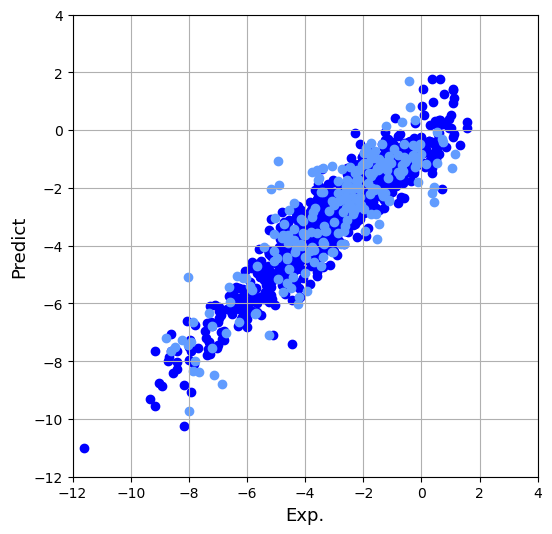

In [45]:
plt.figure(figsize=(6,6))

plt.scatter(x=Y_train, y=Y_pred_train, c="blue", alpha=1)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

plt.xlabel('Exp.', fontsize=13)
plt.ylabel('Predict', fontsize=13)
plt.xlim(-12,4)
plt.ylim(-12,4)
plt.grid()

plt.show()

### 2-2.部分最小二乗回帰（PLS）

In [48]:
model =  PLSRegression()
model.fit(X_train, Y_train)

PLSRegression()

### 予測値

In [51]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

#predicts the X_test
Y_pred_test = model.predict(X_test)

### MSE

In [54]:
#predicts the X_train
mse = mean_squared_error(Y_train, Y_pred_train)
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 1.091


In [56]:
#predicts the X_test
mse = mean_squared_error(Y_test, Y_pred_test)
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 1.332


### R2スコア

In [59]:
#predicts the X_train
r2 = r2_score(Y_train, Y_pred_train)
print('決定係数 (R^2): {:.3f}'.format(r2))

決定係数 (R^2): 0.747


In [61]:
#predicts the X_test
r2 = r2_score(Y_test, Y_pred_test)
print('決定係数 (R^2): {:.3f}'.format(r2))

決定係数 (R^2): 0.718


### MAE

In [64]:
#predicts the X_train
mae = mean_absolute_error(Y_train, Y_pred_train)
print('平均絶対誤差（MAE） : {:.3f}'.format(mae))

平均絶対誤差（MAE） : 0.820


In [66]:
#predicts the X_test
mae = mean_absolute_error(Y_test, Y_pred_test)
print('平均絶対誤差（MAE） : {:.3f}'.format(mae))

平均絶対誤差（MAE） : 0.899


### RMSE

In [69]:
#predicts the X_train
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('二乗平均平方誤差(RMSE) : {:.3f}'.format(rmse))

二乗平均平方誤差(RMSE) : 1.045


In [71]:
#predicts the X_test
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('二乗平均平方誤差(RMSE) : {:.3f}'.format(rmse))

二乗平均平方誤差(RMSE) : 1.154


### Experimental-Predict Plot

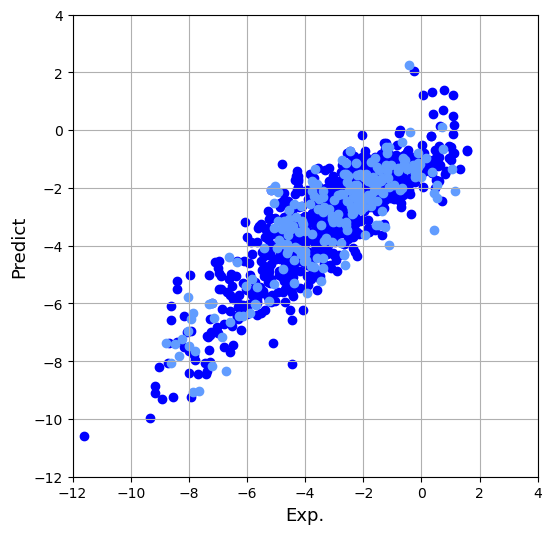

In [74]:
plt.figure(figsize=(6,6))

plt.scatter(x=Y_train, y=Y_pred_train, c="blue", alpha=1)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

plt.xlabel('Exp.', fontsize=13)
plt.ylabel('Predict', fontsize=13)
plt.xlim(-12,4)
plt.ylim(-12,4)
plt.grid()

plt.show()

### 2-3.ランダムフォレスト回帰（RFR）

In [77]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

### 予測値

In [79]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

#predicts the X_test
Y_pred_test = model.predict(X_test)

### MSE

In [81]:
#predicts the X_train
mse = mean_squared_error(Y_train, Y_pred_train)
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 0.135


In [82]:
#predicts the X_test
mse = mean_squared_error(Y_test, Y_pred_test)
print('平均二乗誤差 (MSE): {:.3f}'.format(mse))

平均二乗誤差 (MSE): 0.869


### R2スコア

In [84]:
#predicts the X_train
r2 = r2_score(Y_train, Y_pred_train)
print('決定係数 (R^2): {:.3f}'.format(r2))

決定係数 (R^2): 0.969


In [85]:
#predicts the X_test
r2 = r2_score(Y_test, Y_pred_test)
print('決定係数 (R^2): {:.3f}'.format(r2))

決定係数 (R^2): 0.816


### MAE

In [93]:
#predicts the X_train
mae = mean_absolute_error(Y_train, Y_pred_train)
print('平均絶対誤差（MAE） : {:.3f}'.format(mae))

平均絶対誤差（MAE） : 0.279


In [94]:
#predicts the X_test
mae = mean_absolute_error(Y_test, Y_pred_test)
print('平均絶対誤差（MAE） : {:.3f}'.format(mae))

平均絶対誤差（MAE） : 0.691


### RMSE

In [98]:
#predicts the X_train
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('二乗平均平方誤差(RMSE) : {:.3f}'.format(rmse))

二乗平均平方誤差(RMSE) : 0.368


In [100]:
#predicts the X_test
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('二乗平均平方誤差(RMSE) : {:.3f}'.format(rmse))

二乗平均平方誤差(RMSE) : 0.932


### Experimental-Predict Plot

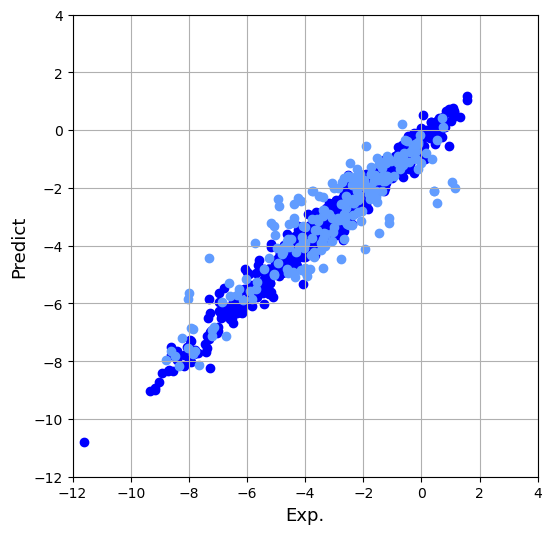

In [103]:
plt.figure(figsize=(6,6))

plt.scatter(x=Y_train, y=Y_pred_train, c="blue", alpha=1)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

plt.xlabel('Exp.', fontsize=13)
plt.ylabel('Predict', fontsize=13)
plt.xlim(-12,4)
plt.ylim(-12,4)
plt.grid()

plt.show()

## PLSによる最適な記述子の探索（P.131）
MorganフィンガープリントおよびRDKit記述子を特徴量とする２ケースについて検討します。

### (1) Morganフィンガープリントの場合

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [108]:
df_train, df_test = train_test_split(df, 
                                     test_size=.20, 
                                     random_state=42)

In [110]:
TARGET=['measured log solubility in mols per litre']
ytrain = df_train[TARGET]
ytrain

,measured log solubility in mols per litre
876,-1.400
712,-0.390
554,-4.400
688,-2.676
780,-8.000
...,...
121,-4.800
1044,-2.120
1095,-3.620
860,-0.460


In [112]:
params={'n_components': np.arange(1,16)}
scores = np.zeros((18,3))
count = 0

for radius in range(1, 4):
    for n_bits in 2**np.arange(5, 11):
        model = GridSearchCV(PLSRegression(), params, cv=5)
        Xtrain = HashedMorgan(n_bits, radius).fit_transform(df_train['mol'])

        model.fit(Xtrain, ytrain)
        
        score_cv = model.best_score_
        scores[count,:] = np.array([radius, n_bits, score_cv])
        count+=1 

[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerator
[23:05:21] DEPRECATION WARNING: please use MorganGenerat

### スコアの表示
交差検定の結果を表示します。横軸に半径、縦軸にはビット数としてR2スコアを色別して表示します。

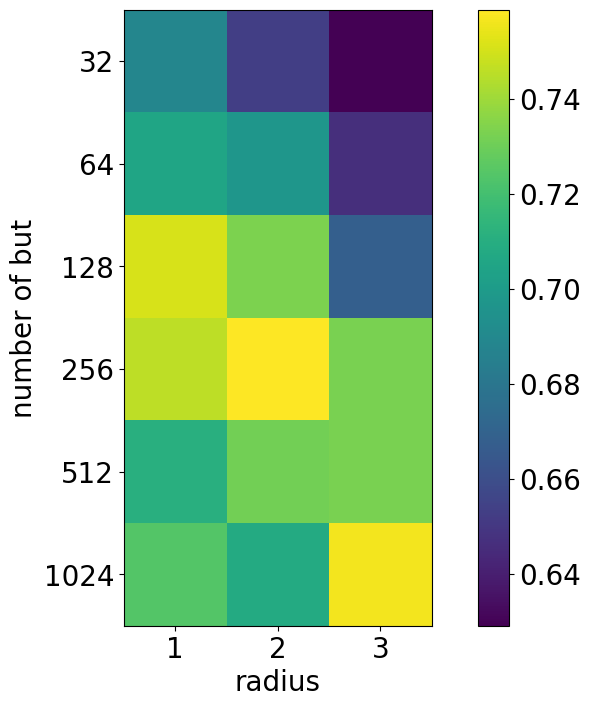

In [114]:
mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['font.size'] = 20

fig,ax=plt.subplots()
im = ax.imshow(scores[:,-1].reshape(3,6).T)
fig.colorbar(im)

ax.set_xticks(range(3))
ax.set_yticks(range(6))
ax.set_xticklabels(range(1,4))
ax.set_yticklabels(map(int,scores[:6,1]))

plt.xlabel('radius')
plt.ylabel('number of but')
#plt.savefig('./results/10.3-optim-hashedmorgan-pls.jpg')

plt.show()

### 最良のパラメータを確認
グリッドサーチによる最良のパラメーターは半径２、ビット数256のときにR2スコアとして0.76が得られました。

In [116]:
ix=scores[:,-1].argmax()
print('radius: {}, n_bits: {} R^2:{:.3f}'.format(*scores[ix,:]))

radius: 2.0, n_bits: 256.0 R^2:0.759


### (2) RDKit記述子の場合(P.132)
同様にしてRDKit記述子についても機械学習モデルを生成してみましょう。

In [118]:
from cheminfo.descriptors import RDKitDescriptor

rdcalc = RDKitDescriptor()

X = rdcalc.fit_transform(df_train['mol'])
Xtrain = np.array(X.tolist())

X2 = rdcalc.transform(df_test['mol'])
Xtest = np.array(X2.tolist())

[23:05:58] DEPRECATION WARNING: please use MorganGenerator
[23:05:58] DEPRECATION WARNING: please use MorganGenerator
[23:05:58] DEPRECATION WARNING: please use MorganGenerator
[23:05:58] DEPRECATION WARNING: please use MorganGenerator
[23:05:58] DEPRECATION WARNING: please use MorganGenerator
[23:05:58] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerator
[23:05:59] DEPRECATION WARNING: please use MorganGenerat

In [119]:
ytest = df_test[TARGET]

In [120]:
params = {'n_components': np.arange(1, 16)}
optim = GridSearchCV(PLSRegression(), params)

In [121]:
optim.fit(Xtrain, ytrain)

GridSearchCV(estimator=PLSRegression(),
             param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

### 予測値

In [123]:
ycalc = optim.predict(Xtrain)
ypred = optim.predict(Xtest)

### 評価値（R2スコア）

In [125]:
print('calc: %.3f'%metrics.r2_score(ytrain,ycalc))
print('cv: %.3f'%optim.best_score_)
print('pred: %.3f'%metrics.r2_score(ytest,ypred))

calc: 0.922
cv: 0.886
pred: 0.892


RDKit記述子の場合は学習データでR2スコアが0.92、検証データで0.89と高い精度になっています。

### Experimental-Predict Plot
RDKitのExperimental-Predictプロット（Exp-Predictプロット）を描画します。

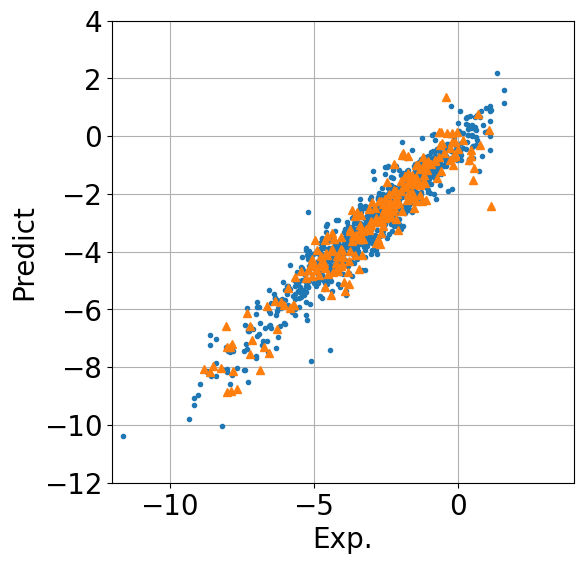

In [128]:
plt.figure(figsize=(6,6))

plt.plot(ytrain, ycalc, '.')
plt.plot(ytest, ypred, '^')
#plt.plot()

plt.axis('square')
plt.xlabel('Exp.')
plt.ylabel('Predict')

plt.xlim(-12,4)
plt.ylim(-12,4)
plt.grid()

#plt.savefig('./results/9.3-yyplot-rdkitpls.jpg')
plt.show()

### モデル保存
上記の予測モデルを保存します。ここではjoblibを使って保存します。

In [130]:
from joblib import dump
dump(optim, './models/9.3_rdkit_pls.joblib')

['./models/9.3_rdkit_pls.joblib']

joblibは、Pythonのパッケージであり、効率的な並列処理やデータのシリアル化（直列化）をサポートするためのツールです。主な用途は、大規模な計算やデータ処理を高速化するために使用されます。joblibは、NumPyの多次元配列や他のPythonオブジェクトをシリアル化してディスクに保存し、後で再ロードすることで、再計算を回避することができます。

joblibの主な特徴は次のとおりです：

1. 並列処理のサポート：joblibは、マルチコアプロセッサを活用して並列計算を行うことができます。これにより、CPUの複数コアを使用して計算を高速化することができます。特に、大量のデータを処理する際に有効です。

2. メモリ効率の向上：joblibは、メモリ使用量を最小限に抑えるために、効率的なメモリマッピングを使用します。これにより、大規模なデータセットを処理する際のメモリオーバーヘッドを軽減できます。

3. シンプルなAPI：joblibは、Pythonの標準ライブラリの`pickle`モジュールと似たシンプルなAPIを提供します。これにより、既存のコードを比較的簡単にjoblibに移行できます。

joblibの主なユースケースは、機械学習やデータサイエンス、大規模なデータ処理などです。特に、機械学習のモデルのトレーニングやハイパーパラメータの探索など、計算が重い処理において高い効果を発揮します。

使用例を示します：

```python
import joblib

# シリアル化（オブジェクトの保存）
data = [1, 2, 3, 4, 5]
joblib.dump(data, 'data.pkl')

# ロード（オブジェクトの読み込み）
loaded_data = joblib.load('data.pkl')
print(loaded_data)  # [1, 2, 3, 4, 5]
```

この例では、Pythonリスト`data`を`data.pkl`というファイル名で保存し、再度読み込んでいます。このようにして、データの保存と再利用が可能となります。

### 【参考】：ハッシュ化されたMorganフィンガープリントの生成の方法（P.127）
Morganフィンガープリントは、指定された半径（半径は整数で指定）を持つ原子および結合の周りに存在する原子と結合のパターンを考慮して計算されます。この処理はハッシュ化処理と呼ばれ、結果はハッシュ値として返されます。これにより、非常に大きなビットベクトルを効率的に表現できます。なおここでハッシュ化処理とは、フラグメントの出現回数を折りたたんで固定長のベクトルを出力する処理です。

ここではトルエンを例に、`GetHashedMorganFingerprint()`メソッドよりハッシュ化されたMorganフィンガープリントを取得する方法を見てみることにします。

In [133]:
toluene = Chem.MolFromSmiles('Cc1ccccc1')
hmfp = GetHashedMorganFingerprint(mol=toluene, radius=3, nBits=512)

[23:06:15] DEPRECATION WARNING: please use MorganGenerator


【解説】`GetHashedMorganFingerprint()`関数とは

`GetHashedMorganFingerprint()`関数は、分子のMorgan（またはCircular）フィンガープリントを計算します。Morganフィンガープリントは、分子中の原子および結合を取り込んだ非常に有用な特徴ベクトルです。

`GetMorganFingerprint()`関数との違い  
`GetMorganFingerprint()`関数と`GetHashedMorganFingerprint()`関数の主な違いは、返されるデータの形式です。

1. `GetMorganFingerprint()`関数:
   - 返り値: ビットベクトル（RDKitのExplicitBitVectクラス）またはカウンティベクトル（RDKitのIntVectクラス）を返します。
   - データ形式: ビットベクトルは明示的な0と1のビットで構成され、1がフィンガープリントに存在するフィーチャーを示し、0が存在しないことを示します。
   - 使用例: 2D類似性検索など、フィンガープリントのバイナリ表現を必要とする場合に使用されます。

2. `GetHashedMorganFingerprint()`関数:
   - 返り値: ハッシュ値のリストを返します。各ハッシュ値は、指定されたビット長（デフォルトは2048）にハッシュされます。
   - データ形式: ビットベクトルよりもコンパクトであり、類似性検索などの場合に効率的に使用できます。
   - 使用例: 類似性検索や機械学習モデルへの入力など、ハッシュされた指紋データを利用する場合に使用されます。
   
 なお、`GetHashedMorganFingerprint() `のデフォルトでは`use features`=Falseオプションとなっており、ECFP (拡張接続フィンガープリント)」に該当します。

どちらの関数を使用するかは、具体的な用途によって異なります。

ビットベクトルから非ゼロのビットのインデックスを見てみましょう

In [137]:
hmfp.GetNonzeroElements()

{31: 2,
 33: 1,
 64: 3,
 175: 2,
 186: 1,
 214: 2,
 287: 1,
 309: 1,
 337: 5,
 356: 1,
 384: 1,
 389: 1,
 411: 1}

【解説】`GetNonzeroElements()`  
ビットベクトルから非ゼロのビットのインデックスと値のペアを取得するために使用されます。この関数は主にフィンガープリントなどのバイナリデータを表すのに使用されます。

ビットベクトルは、ビット長に対して非常に多くのゼロビットを含む場合がありますが、多くの場合、非ゼロのビット（1のビット）のみが重要です。`GetNonzeroElements()`関数は、非ゼロのビットのインデックスとその値（通常は1）のペアを取得することで、効率的に非ゼロの要素だけを取り出すことができます。

`GetNonzeroElements()`関数の構文は以下の通りです:

```python
def GetNonzeroElements(bitVect)
```

- `bitVect`: ExplicitBitVectオブジェクト（明示的なビットベクトル）。これは通常、フィンガープリントなどのバイナリデータを表現するために使用されます。

## 【参考】ハッシュ化されたMorganフィンガープリントを出力するクラス
船津先生のオリジナルであるMorganフィンガープリント（頻度）を取り出す`HashedMorgan`クラスを使ってヒストグラムを作成します。

In [140]:
from cheminfo.descriptors import HashedMorgan

hm = HashedMorgan()
X = hm.fit_transform(df['mol'])

[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerator
[23:06:15] DEPRECATION WARNING: please use MorganGenerat

In [141]:
X.shape

(1128, 512)

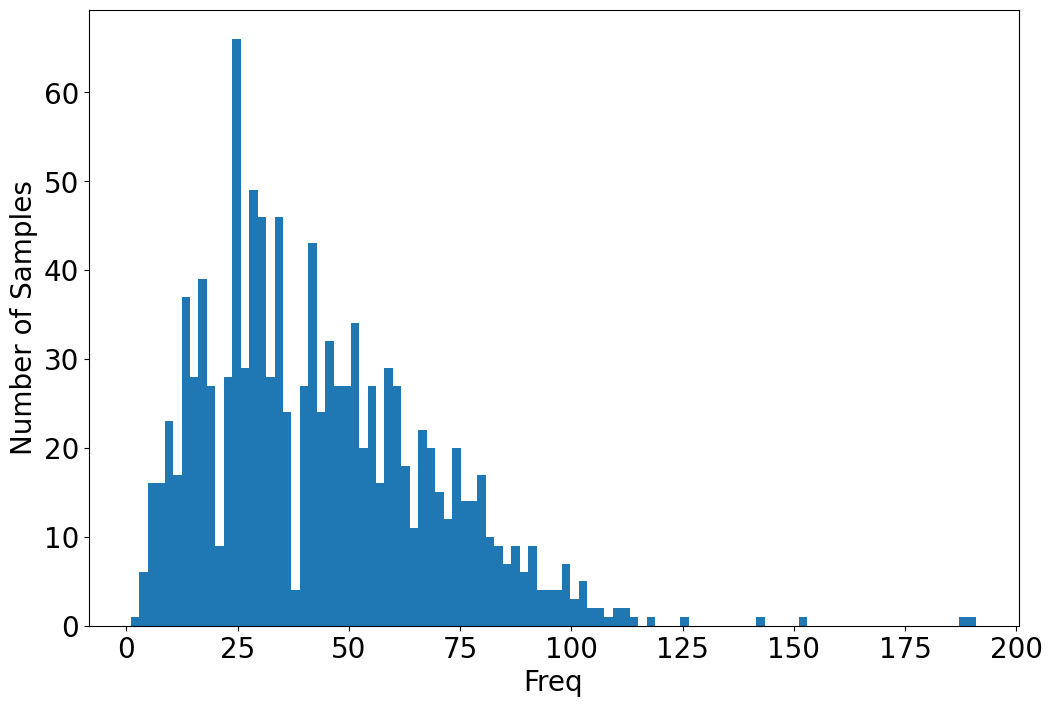

In [142]:
plt.hist(X.sum(axis=1), bins=100)

plt.xlabel('Freq')
plt.ylabel('Number of Samples')
plt.show()